In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./../data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./../data/item_categories.csv
./../data/sales_train.csv
./../data/items_en.csv
./../data/shops.csv
./../data/sample_submission.csv
./../data/items.csv
./../data/item_categories_en.csv
./../data/test.csv
./../data/shops_en.csv


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf


from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
item_cat=pd.read_csv('./../data/item_categories.csv')
item = pd.read_csv('./../data/items.csv')
sales_train=pd.read_csv('./../data/sales_train.csv')
shops = pd.read_csv('./../data/shops.csv')
test = pd.read_csv('./../data/test.csv')

# -I.DATA UNDERSTANDING-

In [4]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [5]:
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [9]:
sales_train.shape

(2935849, 6)

In [10]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [11]:
sales_train["date"]=pd.to_datetime(sales_train["date"])

In [12]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [13]:
import datetime as dt
sales_train['day'] = sales_train['date'].dt.day
sales_train['month'] = sales_train["date"].dt.month
sales_train['year'] = sales_train["date"].dt.year

In [14]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,2013-02-01,0,59,22154,999.00,1.0,1,2,2013
1,2013-03-01,0,25,2552,899.00,1.0,1,3,2013
2,2013-05-01,0,25,2552,899.00,-1.0,1,5,2013
3,2013-06-01,0,25,2554,1709.05,1.0,1,6,2013
4,2013-01-15,0,25,2555,1099.00,1.0,15,1,2013


## Montly Sales

In [15]:
monthly_sales = sales_train.groupby(["date_block_num","shop_id","item_id"]).agg({"item_price":"mean","item_cnt_day":"sum"})

monthly_sales.head()

item_price  item_cnt_day
date_block_num shop_id item_id                          
0              0       32            221.0           6.0
                       33            347.0           3.0
                       35            247.0           1.0
                       43            221.0           1.0
                       51            128.5           2.0

## Allover Daily Sales

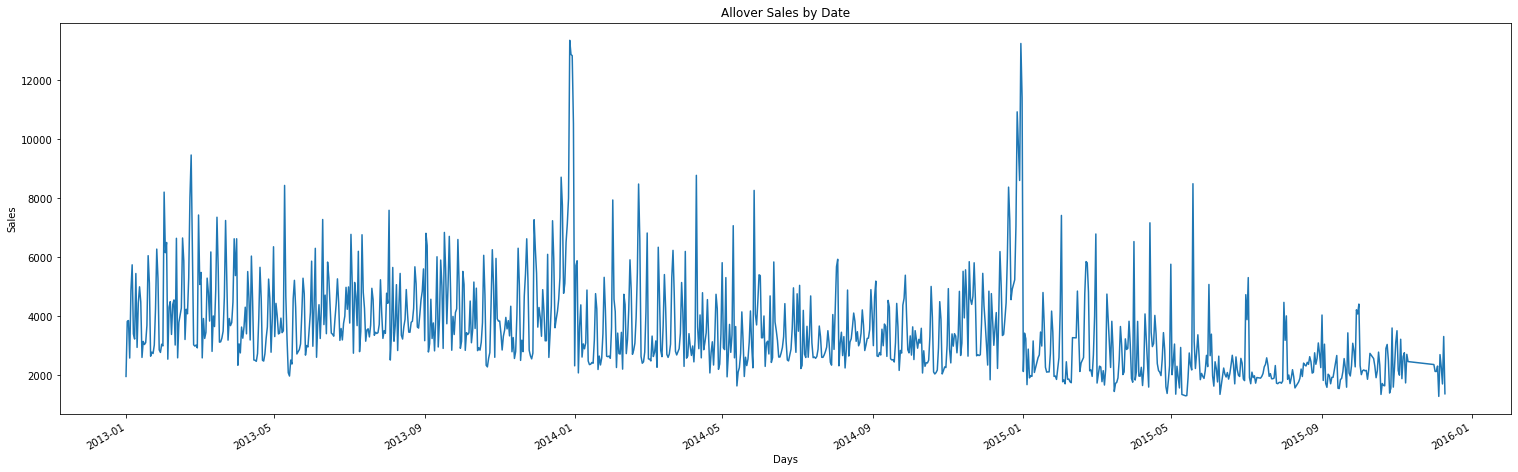

In [16]:
allover_sales_by_date = sales_train.groupby(["date"])["item_cnt_day"].sum()
allover_sales_by_date.plot(kind="line",
                     xlabel="Days",
                     ylabel="Sales",
                     title= "Allover Sales by Date",
                     figsize=(26,8));

# -II.DATA ANALYSIS-

# 1. Types of Time-Series

Time-series are of generally two types:

    * Additive Time-Series: Additive time-series is time-series where components (trend, seasonality, noise) are added to generate time series.
    
        Time-Series = trend + seasonality + noise
        
    * Multiplicative Time-Series: Multiplicative time-series is time-series where components (trend, seasonality, noise) are multiplied to generate time series. One can notice an increase in the amplitude of seasonality in multiplicative time-series.
    
        Time-Series = trend * seasonality * noise



### MoM Total Daily Sales (continous / time series)

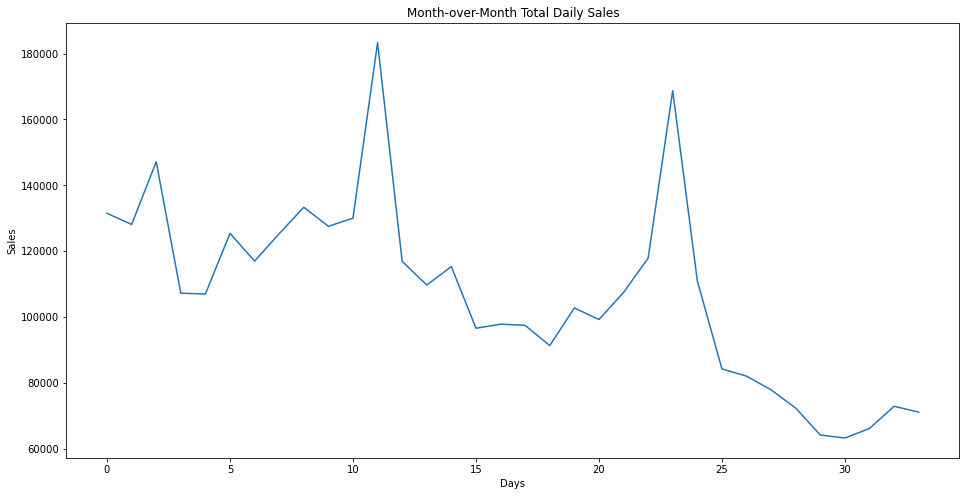

In [17]:
mom_sales =  sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()

mom_sales.plot(kind="line",
                     xlabel="Days",
                     ylabel="Sales",
                     title= "Month-over-Month Total Daily Sales",
                     figsize=(16,8));

# 2. Trend, Seasonality and Stationary


## a.Trend:

    The trends represent an increase or decrease in time-series value over time. If we notice that the value of measurement over time is increasing or decreasing then we can say that it has an upward or downward trend.
    
    How to remove trend from time-series data?

    There are various ways to de-trend a time series. We have explained a few below.

    1. Log Transformation.
    2. Power Transformation.
    3. Local Smoothing - Applying moving window functions to time-series data.
    4. Differencing a time-series.
    5. Linear Regression.
    
    
## b.Seasonality:  

    The seasonality represents variations in measured value which repeats over the same time interval regularly. If we notice that particular variations in value are happening every week, month, quarter or half-yearly then we can say that time series has some kind of seasonality.
    
    How to remove seasonality from time-series data?
    
    Average de-trended values.
    Differencing a time-series.
    Use the loess method.

    (There are various ways to remove seasonality. The task of removing seasonality is a bit complicated. We have explained a few ways below to remove seasonality.)

    
    
## c.Stationary 
    
    If there is a upward or downward trend, or multiplative waving condition, or irregular waving trend in time series, it points to a Non-Stationary time serie. 
    To proceed the analysis, we need to convert it to Stationary timeseries.
    
    There are multiple tests that can be used to check stationarity as well.

    1. ADF( Augmented Dicky Fuller Test)
    2. KPSS
    3. PP (Phillips-Perron test)

    



- Let's check the trend seasonality and stationarity of our time serie visualizing its mean and standard deviation 


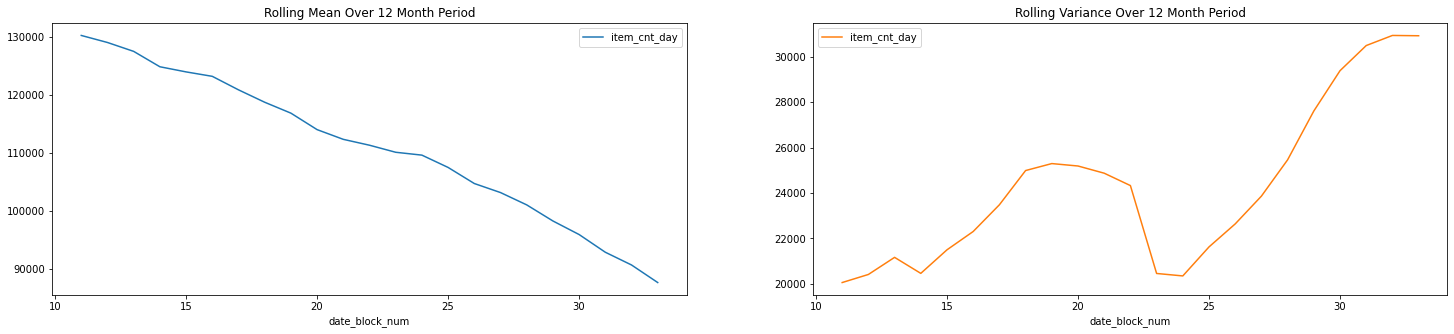

In [18]:
plt.subplot(121)
mom_sales.rolling(window = 12).mean().plot(figsize=(25,5), 
                                                 color="tab:blue", 
                                                 title="Rolling Mean Over 12 Month Period", 
                                                 legend = True);
plt.subplot(122)
mom_sales.rolling(window = 12).std().plot(color="tab:orange", 
                                                title="Rolling Variance Over 12 Month Period", 
                                                legend=True);

It is seen that there is a descending additive trend in mean whereas ascending and increasing multivative trend in variance.

# 3. Decompose Time Series To Its Components

    Normally there is 2 decompose model as "multiplicative" model and "additive" model. We will prefer additive model assessing no multiplative condition in the serie.

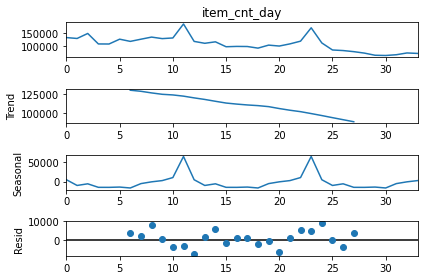

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result = seasonal_decompose(mom_sales, freq=12, model="additive")
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

## 4. Stationary Testing with Dicky-Fuller 

In [20]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['1.Test Statistic','2.p-value','3.Lags Used','4.Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['5.Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(mom_sales)

Results of Dickey-Fuller Test:
1.Test Statistic                 -2.395704
2.p-value                         0.142953
3.Lags Used                       0.000000
4.Number of Observations Used    33.000000
5.Critical Value (1%)            -3.646135
5.Critical Value (5%)            -2.954127
5.Critical Value (10%)           -2.615968
dtype: float64


    We can interpret above results based on p-values of result.
    1. p-value > 0.05 - This implies that time-series is non-stationary.
    2. p-value <=0.05 - This implies that time-series is stationary
                
    Since P-value is greater than 0.05, our time-series is not stationary. It has time-dependent components present that we need to remove.                

# -III.DATA PREPROCESSING-

## Remove Trend and Seasonality

    There are various ways like differencing, power transformation, log transformation, etc. to remove trends from data as we have discussed above. 
    
    We'll practice differencing.

In [21]:
# create a differencing series to remove trend

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)


[]

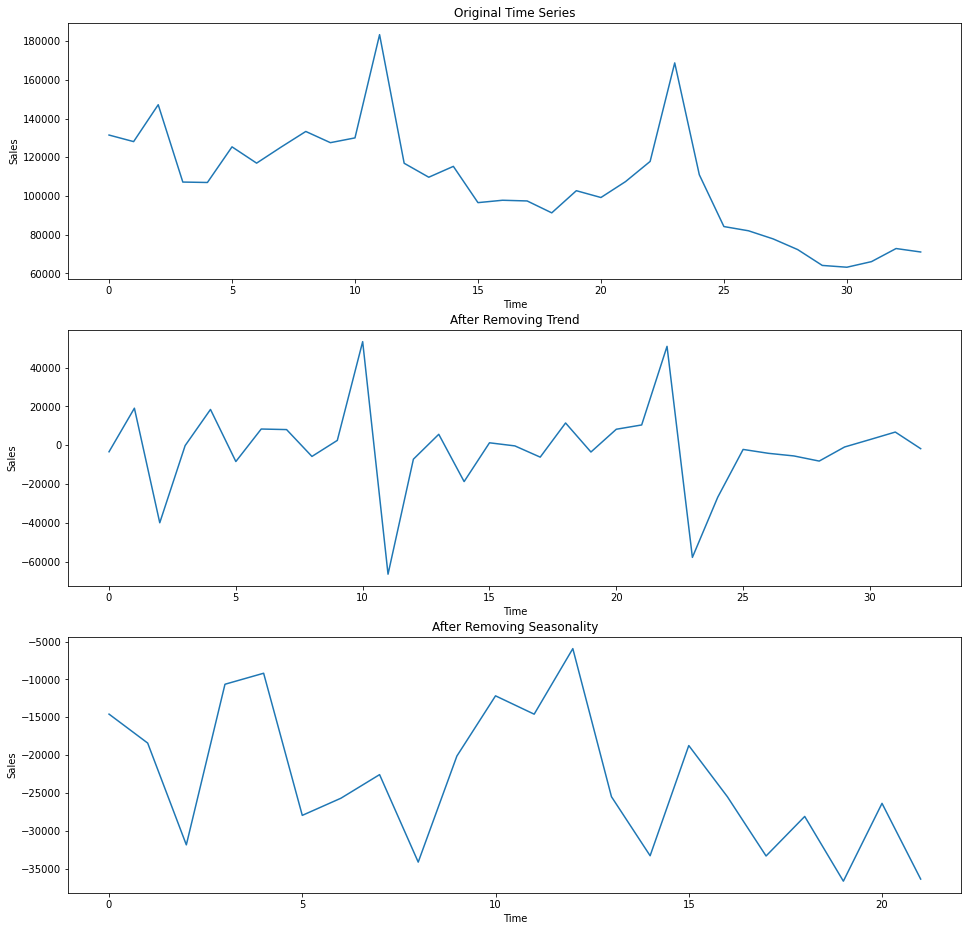

In [22]:
ts=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original Time Series')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

plt.subplot(312)
plt.title('After Removing Trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After Removing Seasonality')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [23]:
# now testing the stationarity again after removing trend and seasonality

test_stationarity(new_ts)


Results of Dickey-Fuller Test:
1.Test Statistic                 -3.270101
2.p-value                         0.016269
3.Lags Used                       0.000000
4.Number of Observations Used    21.000000
5.Critical Value (1%)            -3.788386
5.Critical Value (5%)            -3.013098
5.Critical Value (10%)           -2.646397
dtype: float64


    Now after the transformations, our p-value for the Dickey Fuller Test is within 5 %. So we can assume Stationarity of the series.

# -IV.PREDICTIVE ANALYSIS / FORECASTING- 

## AR, MA and ARMA (Autoregressive Moving Average) models:

In [24]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

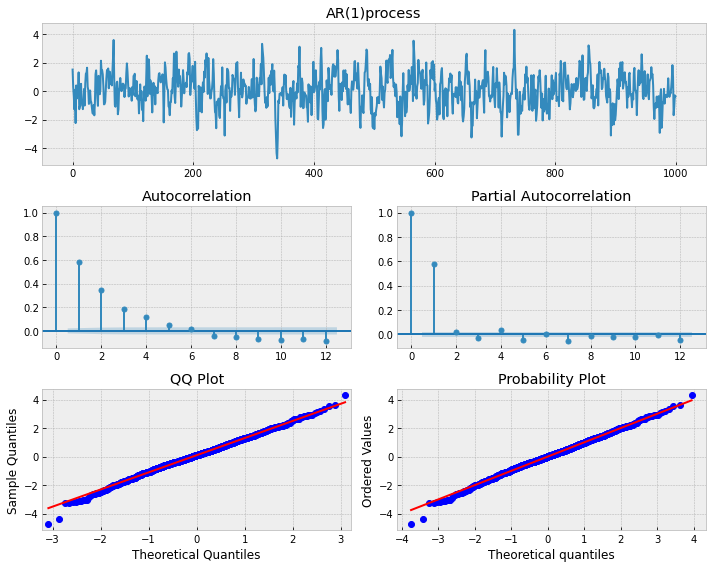

In [25]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

## AR(1) process -- has ACF tailing out and PACF cutting off at lag=1

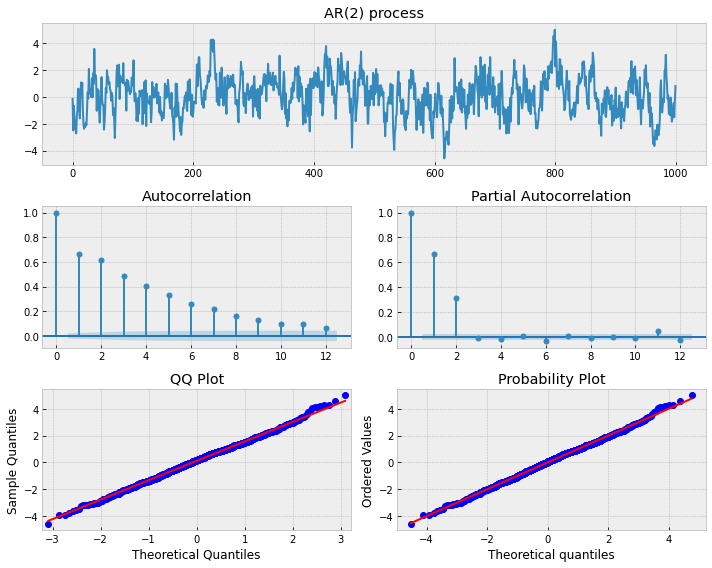

In [26]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

## AR(2) process -- has ACF tailing out and PACF cutting off at lag=2

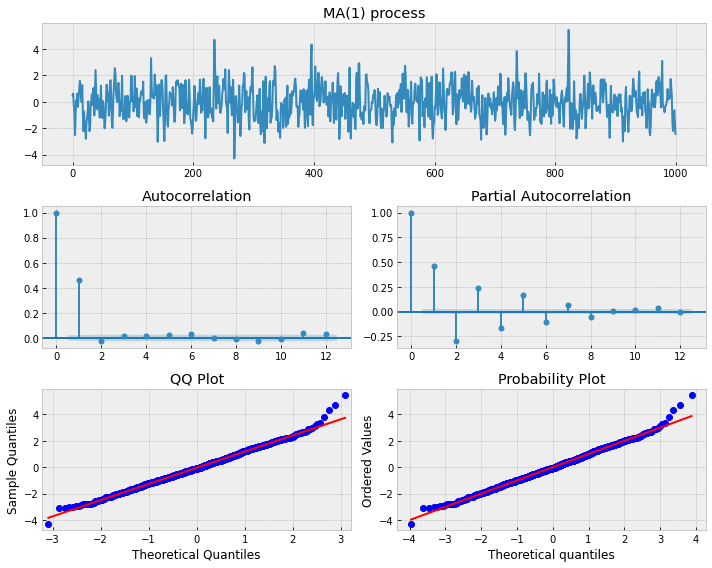

In [27]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

## MA(1) process -- has ACF cut off at lag=1

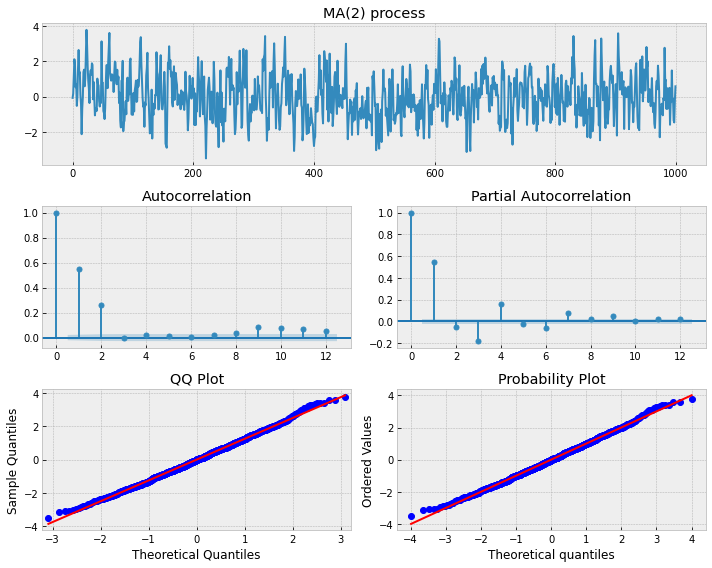

In [28]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

## MA(2) process -- has ACF cut off at lag=2

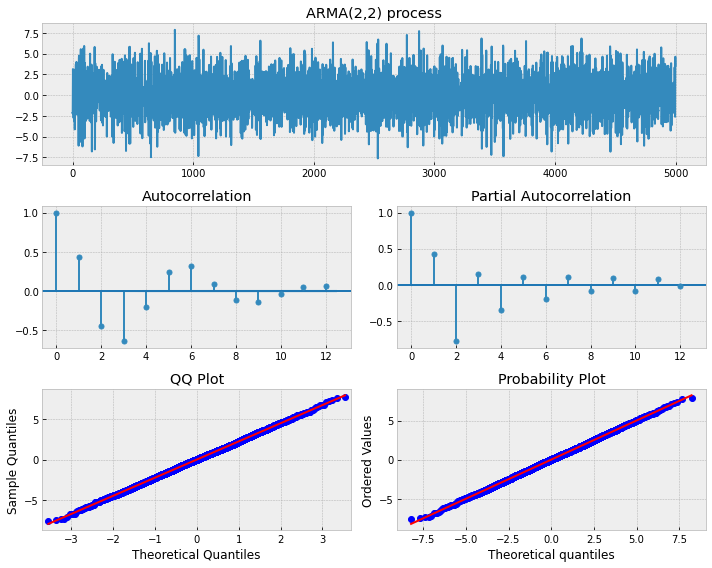

In [29]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

- Its not very clear/straight-forward. Let's use a systematic approach to finding the order of AR and MA processes.

In [30]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 15326.68109 | order: (2, 2)


## We've correctly identified the order of the simulated process as ARMA(2,2)

     Lets use it for the sales time-series.

In [31]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 472.99703 | order: (1, 1)


### Simply use best_mdl.predict() to predict the next values

In [33]:
# adding the dates to the Time-series as index
ts=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
print(ts)
ts=ts.reset_index()
ts.head()

2013-01-01    131479.0
2013-02-01    128090.0
2013-03-01    147142.0
2013-04-01    107190.0
2013-05-01    106970.0
2013-06-01    125381.0
2013-07-01    116966.0
2013-08-01    125291.0
2013-09-01    133332.0
2013-10-01    127541.0
2013-11-01    130009.0
2013-12-01    183342.0
2014-01-01    116899.0
2014-02-01    109687.0
2014-03-01    115297.0
2014-04-01     96556.0
2014-05-01     97790.0
2014-06-01     97429.0
2014-07-01     91280.0
2014-08-01    102721.0
2014-09-01     99208.0
2014-10-01    107422.0
2014-11-01    117845.0
2014-12-01    168755.0
2015-01-01    110971.0
2015-02-01     84198.0
2015-03-01     82014.0
2015-04-01     77827.0
2015-05-01     72295.0
2015-06-01     64114.0
2015-07-01     63187.0
2015-08-01     66079.0
2015-09-01     72843.0
2015-10-01     71056.0
Freq: MS, Name: item_cnt_day, dtype: float64


,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


## Prophet:

    Recently open-sourced by Facebook research. It's a very promising tool, that is often a very handy and quick solution to the frustrating flatline.
    
    Sure, one could argue that with proper pre-processing and carefully tuning the parameters the above graph would not happen.

    But the truth is that most of us don't either have the patience or the expertise to make it happen.

    Also, there is the fact that in most practical scenarios- there is often a lot of time-series that needs to be predicted. Eg: This competition. It requires us to predict the next month sales for the Store - item level combinations which could be in the thousands.(ie) predict 1000s of parameters!

    Another neat functionality is that it follows the typical sklearn syntax.

    At its core, the Prophet procedure is an additive regression model with four main components:

    A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
    A yearly seasonal component modeled using Fourier series.
    A weekly seasonal component using dummy variables.
    A user-provided list of important holidays.

   Resources for learning more about prophet:

   https://www.youtube.com/watch?v=95-HMzxsghY \
   https://facebook.github.io/prophet/docs/quick_start.html#python-api \
   https://research.fb.com/prophet-forecasting-at-scale/ \
   https://blog.exploratory.io/is-prophet-better-than-arima-for-forecasting-time-series-fa9ae08a5851


In [47]:
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
ts.columns=['ds','y']
print(ts)
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

Importing plotly failed. Interactive plots will not work.


           ds         y
0  2013-01-01  131479.0
1  2013-02-01  128090.0
2  2013-03-01  147142.0
3  2013-04-01  107190.0
4  2013-05-01  106970.0
5  2013-06-01  125381.0
6  2013-07-01  116966.0
7  2013-08-01  125291.0
8  2013-09-01  133332.0
9  2013-10-01  127541.0
10 2013-11-01  130009.0
11 2013-12-01  183342.0
12 2014-01-01  116899.0
13 2014-02-01  109687.0
14 2014-03-01  115297.0
15 2014-04-01   96556.0
16 2014-05-01   97790.0
17 2014-06-01   97429.0
18 2014-07-01   91280.0
19 2014-08-01  102721.0
20 2014-09-01   99208.0
21 2014-10-01  107422.0
22 2014-11-01  117845.0
23 2014-12-01  168755.0
24 2015-01-01  110971.0
25 2015-02-01   84198.0
26 2015-03-01   82014.0
27 2015-04-01   77827.0
28 2015-05-01   72295.0
29 2015-06-01   64114.0
30 2015-07-01   63187.0
31 2015-08-01   66079.0
32 2015-09-01   72843.0
33 2015-10-01   71056.0


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
ts.columns=['ds','y']
print(ts)

           ds         y
0  2013-01-01  131479.0
1  2013-02-01  128090.0
2  2013-03-01  147142.0
3  2013-04-01  107190.0
4  2013-05-01  106970.0
5  2013-06-01  125381.0
6  2013-07-01  116966.0
7  2013-08-01  125291.0
8  2013-09-01  133332.0
9  2013-10-01  127541.0
10 2013-11-01  130009.0
11 2013-12-01  183342.0
12 2014-01-01  116899.0
13 2014-02-01  109687.0
14 2014-03-01  115297.0
15 2014-04-01   96556.0
16 2014-05-01   97790.0
17 2014-06-01   97429.0
18 2014-07-01   91280.0
19 2014-08-01  102721.0
20 2014-09-01   99208.0
21 2014-10-01  107422.0
22 2014-11-01  117845.0
23 2014-12-01  168755.0
24 2015-01-01  110971.0
25 2015-02-01   84198.0
26 2015-03-01   82014.0
27 2015-04-01   77827.0
28 2015-05-01   72295.0
29 2015-06-01   64114.0
30 2015-07-01   63187.0
31 2015-08-01   66079.0
32 2015-09-01   72843.0
33 2015-10-01   71056.0


In [48]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,83193.957175,80157.850148,86253.821834
35,2015-12-01,125513.062865,122507.614723,128527.676767
36,2016-01-01,75625.688457,72334.504264,78761.261980
37,2016-02-01,40109.144355,36826.923935,43146.889362
38,2016-03-01,76664.084568,73570.379790,79724.131754


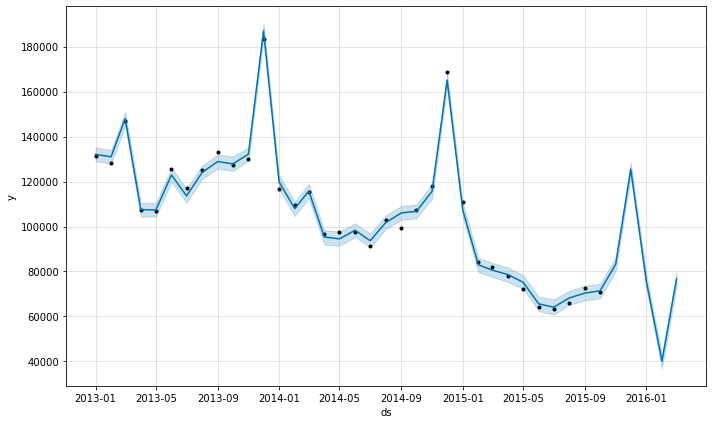

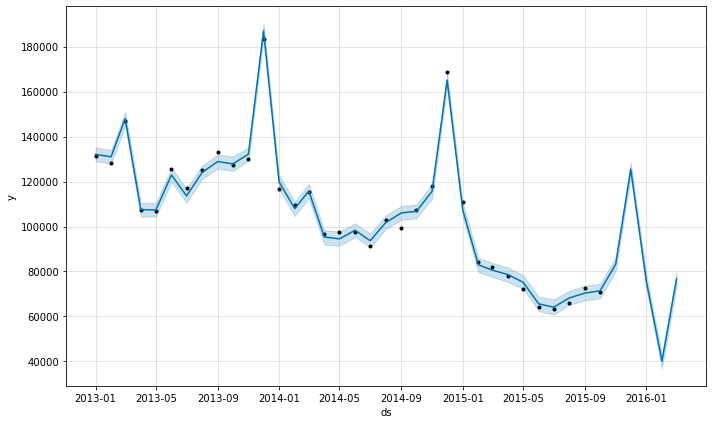

In [49]:
model.plot(forecast)

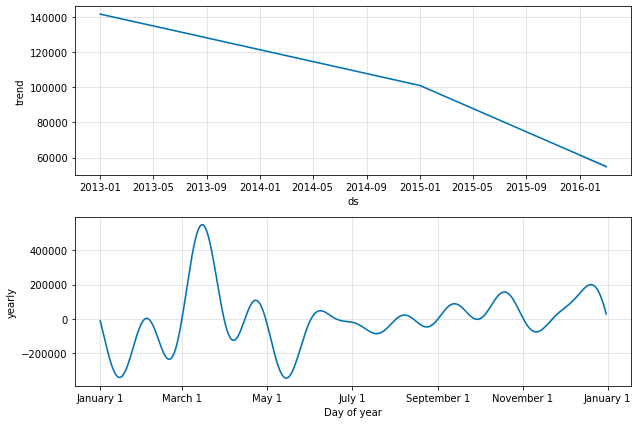

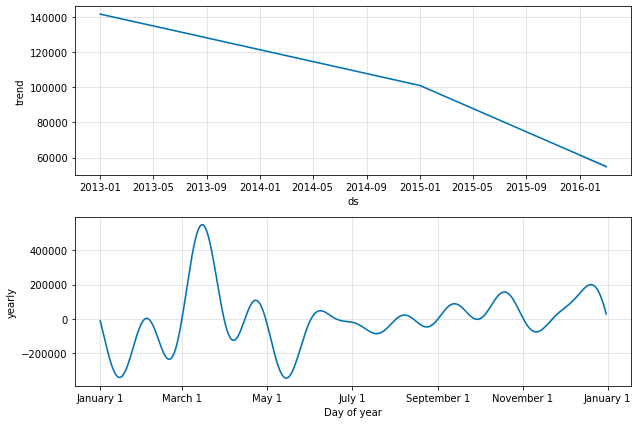

In [50]:
model.plot_components(forecast)

    The trend and seasonality from Prophet look similar to the ones that we had earlier using the traditional methods.

## Hierarchical time series:

In [51]:
total_sales=sales_train.groupby(['date_block_num'])["item_cnt_day"].sum()
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')

total_sales.index=dates
total_sales.head()

2013-01-01    131479.0
2013-02-01    128090.0
2013-03-01    147142.0
2013-04-01    107190.0
2013-05-01    106970.0
Freq: MS, Name: item_cnt_day, dtype: float64

## Middle out:

    Let's predict for the store level

In [52]:
monthly_shop_sales=sales_train.groupby(["date_block_num","shop_id"])["item_cnt_day"].sum()
print(monthly_shop_sales)
# get the shops to the columns
monthly_shop_sales=monthly_shop_sales.unstack(level=1)
print(monthly_shop_sales)
monthly_shop_sales=monthly_shop_sales.fillna(0)
print(monthly_shop_sales)
monthly_shop_sales.index=dates
print(monthly_shop_sales)
monthly_shop_sales=monthly_shop_sales.reset_index()
monthly_shop_sales

date_block_num  shop_id
0               0          5578.0
                1          2947.0
                2          1146.0
                3           767.0
                4          2114.0
                            ...  
33              55         1972.0
                56         1263.0
                57         2316.0
                58         1446.0
                59          790.0
Name: item_cnt_day, Length: 1586, dtype: float64
shop_id             0       1       2       3       4       5       6   \
date_block_num                                                           
0               5578.0  2947.0  1146.0   767.0  2114.0     NaN  3686.0   
1               6127.0  3364.0   488.0   798.0  2025.0   877.0  4007.0   
2                  NaN     NaN   753.0   959.0  2060.0  1355.0  4519.0   
3                  NaN     NaN   583.0   647.0   285.0  1008.0  3168.0   
4                  NaN     NaN   553.0   710.0  1211.0  1110.0  3022.0   
5                  NaN     NaN   83

shop_id,index,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,59
0,2013-01-01,5578.0,2947.0,1146.0,767.0,2114.0,0.0,3686.0,2495.0,1463.0,...,3406.0,2748.0,1812.0,2055.0,9386.0,0.0,3238.0,0.0,0.0,2017.0
1,2013-02-01,6127.0,3364.0,488.0,798.0,2025.0,877.0,4007.0,2513.0,1156.0,...,3054.0,2284.0,1737.0,1906.0,8075.0,0.0,2655.0,0.0,0.0,1897.0
2,2013-03-01,0.0,0.0,753.0,959.0,2060.0,1355.0,4519.0,2460.0,977.0,...,3610.0,2605.0,2034.0,2365.0,9488.0,0.0,3099.0,6586.0,3773.0,2028.0
3,2013-04-01,0.0,0.0,583.0,647.0,285.0,1008.0,3168.0,1540.0,-1.0,...,2740.0,1945.0,1446.0,1515.0,6726.0,0.0,2153.0,5493.0,2831.0,1388.0
4,2013-05-01,0.0,0.0,553.0,710.0,1211.0,1110.0,3022.0,1647.0,0.0,...,2839.0,2243.0,1482.0,1767.0,7006.0,852.0,2140.0,5233.0,2308.0,1374.0
5,2013-06-01,0.0,0.0,832.0,784.0,1464.0,1393.0,3847.0,2085.0,0.0,...,3761.0,2200.0,1815.0,2125.0,8101.0,728.0,3105.0,5987.0,2972.0,1707.0
6,2013-07-01,0.0,0.0,807.0,721.0,1378.0,1265.0,3360.0,2031.0,0.0,...,3235.0,2273.0,1616.0,1975.0,7225.0,795.0,3294.0,5827.0,3122.0,1747.0
7,2013-08-01,0.0,0.0,875.0,890.0,1713.0,1510.0,3702.0,2397.0,0.0,...,3718.0,2142.0,1772.0,2367.0,7792.0,719.0,3311.0,5413.0,2863.0,2048.0
8,2013-09-01,0.0,0.0,945.0,1026.0,1536.0,1298.0,4208.0,2599.0,0.0,...,3655.0,1903.0,2125.0,2440.0,7827.0,812.0,2829.0,5213.0,2735.0,2008.0
9,2013-10-01,0.0,0.0,795.0,793.0,1482.0,1267.0,3675.0,2236.0,0.0,...,3525.0,1809.0,1965.0,2245.0,6676.0,916.0,2375.0,5686.0,3022.0,1751.0


In [ ]:
import time
start_time=time.time()

# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_shop_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_shop_sales.iloc[:,0], monthly_shop_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [ ]:
#predictions = np.zeros([len(forecastsDict[0].yhat),1]) 
nCols = len(list(forecastsDict.keys()))+1
for key in range(0, nCols-1):
    f1 = np.array(forecastsDict[key].yhat)
    f2 = f1[:, np.newaxis]
    if key==0:
        predictions=f2.copy()
       # print(predictions.shape)
    else:
       predictions = np.concatenate((predictions, f2), axis = 1)

In [ ]:
prediction=predictions[-1]
prediction